In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import os
import json
import numpy as np
from collections import defaultdict
from IPython.display import display, HTML

from matplotlib import colors as mcolors
from matplotlib import cm
from mycolorpy import colorlist as mcp
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


In [2]:
dirs = [
        "/home/noah/ESSL/experiments/ssl_testing3/BYOL",
        "/home/noah/ESSL/experiments/ssl_testing3/NNCLR",
       # "/home/noah/ESSL/experiments/ssl_testing3/SimCLR",
        "/home/noah/ESSL/experiments/ssl_testing3/SwaV"
]


# vals = pd.read_csv(os.path.join(dirs[0], "outcomes.csv"))
vals = pd.DataFrame(columns=pd.read_csv(os.path.join(dirs[0], "outcomes.csv")).columns)
for d in dirs:
    f = os.path.join(d, "outcomes.csv")
    f = pd.read_csv(f)
    f["method"] = [os.path.basename(d) for _ in range(len(f))]
    vals = pd.concat([vals, f])

chromo_df = pd.DataFrame()
with open(os.path.join(dirs[0], "chromosomes.json"), "r") as f:
    chromos = json.load(f)
c_strings = []
for i in range(len(chromos)):
    c = chromos[str(i)]
    c = [c_i[0] for c_i in c]
    c_strings.append(" ".join(c))
colors=mcp.gen_color(cmap='Paired',n=len(c_strings))
chromo_colors = {chromo:color for chromo, color in zip(c_strings, colors)}
chromo_df["chromosome"] = c_strings
chromo_colors

{'Brightness ShearX Solarize': '#fb9a99',
 'Contrast Rotate TranslateX': '#a6cee3',
 'ShearY TranslateY Color': '#a6cee3',
 'Color Solarize Sharpness': '#a6cee3',
 'Rotate Color TranslateX': '#b15928',
 'Contrast Solarize ShearX': '#a6cee3',
 'Rotate Sharpness Color': '#6a3d9a',
 'Sharpness Contrast Solarize': '#a6cee3',
 'Sharpness TranslateX TranslateY': '#6a3d9a',
 'ShearX Contrast Rotate': '#ff7f00',
 'ShearY TranslateX Solarize': '#6a3d9a',
 'ShearY Brightness Contrast': '#a6cee3',
 'Solarize Brightness Contrast': '#b15928',
 'Sharpness TranslateX ShearY': '#b15928',
 'TranslateX Brightness Contrast': '#a6cee3',
 'ShearX Sharpness Brightness': '#fb9a99',
 'Contrast Solarize TranslateX': '#a6cee3',
 'TranslateY Sharpness Rotate': '#a6cee3',
 'ShearY TranslateX Contrast': '#ff7f00',
 'Solarize Sharpness Color': '#a6cee3',
 'Contrast ShearY Solarize': '#a6cee3',
 'Sharpness ShearY ShearX': '#1f78b4',
 'Contrast TranslateX Brightness': '#1f78b4',
 'Contrast Color Rotate': '#1f78b4',
 

In [3]:
def colorchromos(val):
    return [f'Background: {chromo_colors[val["chromosome"]]}' for _ in range(len(val))]

In [4]:
for d in dirs:
    try:
        f = os.path.join(d, "outcomes.csv")
        f = pd.read_csv(f)
        method = os.path.basename(d)
        chromo_df[f"{method} test acc"] = f["test acc"]
        chromo_df[f"{method} test loss"] = f["final test loss"]
    except KeyError:
        continue
        
chromo_df = chromo_df.reindex(columns=["chromosome"]+[c for c in chromo_df.columns if "acc" in c] + [c for c in chromo_df.columns if "loss" in c])
chromo_df
vals["chromosome"] = vals["chromosome"].apply(lambda x: c_strings[int(x)])
vals[["chromosome", "method", "test acc", "final test loss"]]
chromo_df.style.apply(colorchromos, axis=0)

for col in [c for c in chromo_df if c != "chromosome"]:
    chromo_df = chromo_df.sort_values(by=col, ascending=False)
    display(HTML(chromo_df[["chromosome", col]].style.apply(colorchromos, axis=1).to_html()))

,chromosome,BYOL test acc
132,Solarize Brightness TranslateX,83.960000
141,Sharpness Contrast ShearX,83.830000
210,TranslateY ShearX Color,83.830000
61,TranslateY Sharpness ShearX,83.800000
212,Color Solarize TranslateY,83.780000
17,TranslateY Sharpness Rotate,83.720000
128,ShearX Brightness Sharpness,83.650000
20,Contrast ShearY Solarize,83.640000
43,ShearX Brightness Color,83.630000
110,Brightness Solarize ShearX,83.630000


,chromosome,NNCLR test acc
64,TranslateY Brightness Sharpness,83.860000
96,Solarize ShearX Contrast,83.800000
128,ShearX Brightness Sharpness,83.750000
156,Color ShearX TranslateY,83.680000
180,Solarize Rotate ShearY,83.640000
85,Solarize Sharpness TranslateY,83.590000
26,TranslateY Rotate ShearY,83.520000
34,Rotate Contrast Brightness,83.470000
43,ShearX Brightness Color,83.460000
137,Color Rotate Sharpness,83.440000


,chromosome,SwaV test acc
169,ShearX TranslateX Brightness,83.830000
22,Contrast TranslateX Brightness,83.750000
16,Contrast Solarize TranslateX,83.710000
20,Contrast ShearY Solarize,83.650000
126,Contrast Brightness ShearY,83.630000
75,ShearY Contrast Rotate,83.610000
235,TranslateY Color Contrast,83.560000
54,TranslateX Solarize Contrast,83.510000
204,Color TranslateX Rotate,83.490000
39,Brightness Color Rotate,83.420000


,chromosome,BYOL test loss
146,Brightness ShearY TranslateX,0.540177
94,ShearY Solarize Brightness,0.535948
162,TranslateY Solarize ShearX,0.534979
35,Solarize Contrast Color,0.532206
159,Rotate TranslateX Contrast,0.531820
38,Rotate ShearX Color,0.531727
88,ShearY Solarize Contrast,0.530449
183,Solarize Rotate TranslateX,0.529996
137,Color Rotate Sharpness,0.529969
216,Solarize Color ShearY,0.529497


,chromosome,NNCLR test loss
74,Solarize TranslateX ShearX,0.571672
163,ShearX Solarize Color,0.567656
206,Brightness Sharpness Rotate,0.554661
198,ShearY Sharpness TranslateX,0.554271
14,TranslateX Brightness Contrast,0.554163
121,ShearY Solarize Brightness,0.553804
57,Rotate Brightness ShearY,0.551751
100,TranslateY Brightness Color,0.549557
221,ShearY Solarize Sharpness,0.545723
120,TranslateX Contrast TranslateY,0.544769


,chromosome,SwaV test loss
90,Color Rotate Sharpness,0.571783
237,TranslateY Solarize Sharpness,0.568257
209,Color TranslateX ShearY,0.564558
172,Rotate TranslateY Color,0.559310
213,TranslateY Rotate Brightness,0.557436
0,Brightness ShearX Solarize,0.555311
114,ShearY TranslateY TranslateX,0.549214
192,Rotate Sharpness Color,0.548463
143,Rotate ShearY Color,0.546526
140,Color Contrast ShearX,0.545797


In [5]:
chromosomes = []
for d in dirs:
    with open(os.path.join(d, "chromosomes.json"), "r") as f:
        chromosomes.append(json.load(f))
# confrim that we used the same chromosomes
for c1 in chromosomes:
    for c2 in chromosomes:
        print(c1 == c2)
        
len(chromosomes)

True
False
True
False
True
False
True
False
True


3

I realize now that because we are using the same random seed, we get the exact same outcome everytime for all 4 experiments. 

In [6]:
# sort based on test acc and test loss and then compute the distance matrix between chromosomes for each method
accuracies = [c for c in chromo_df.columns if "acc" in c]
accuracies

['BYOL test acc', 'NNCLR test acc', 'SwaV test acc']

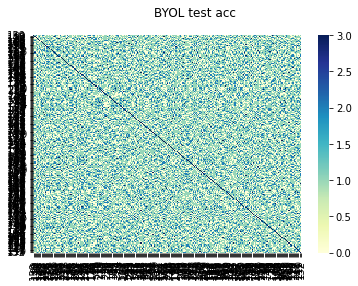

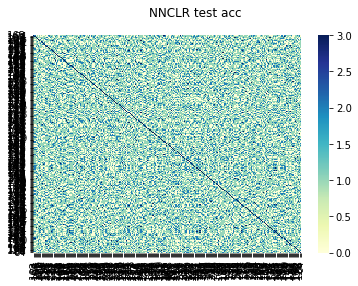

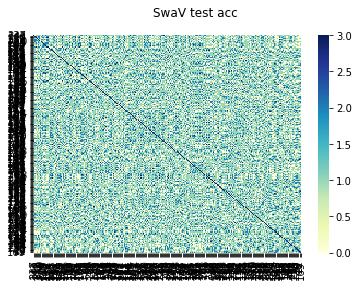

<Figure size 432x288 with 0 Axes>

In [7]:

normalization = {
    "ShearX":[0.0, 0.3],
    "ShearY":[0.0, 0.3],
    "TranslateX":[0, int(150 / 331.0 * 32)],
    "TranslateY":[0, int(150 / 331.0 * 32)],
    "Rotate":[-30, 30],
    "Color":[0.1, 1.9],
    "Posterize":[4, 8],
    "Solarize":[0, 1],
    "Contrast":[0.1,1.9],
    "Sharpness":[0.1, 1.9],
    "Brightness":[0.1, 1.9]
}

def chromo_distance(c1, c2):
    # hammming distance plus intensity differnece
    eq = np.array([int(c1_i[0] == c2_i[0]) for c1_i, c2_i in zip(c1, c2)])
    c1_i = np.array([c[1] for c in c1])
    c2_i = np.array([c[1] for c in c2])
    return sum(eq * np.abs(c2_i - c1_i))

def chromo_distance2(c1, c2, normalization=normalization):
    # intensity difference
    distance = 0
    for c1_i in c1:
        for c2_i in c2:
            if c1_i[0] == c2_i[0]:
                distance+= 1-abs(normalize(c1_i, normalization)[1] - normalize(c2_i, normalization)[1])

    return distance

def chromo_distance3(c1, c2):
    # number of same operators
    similarity = 0
    for c1_i in c1:
        for c2_i in c2:
            if c1_i[0] == c2_i[0]:
                similarity += 1
    return similarity


def normalize(c, normalization):
    return [c[0], (c[1] - normalization[c[0]][0]) / (normalization[c[0]][1] - normalization[c[0]][0])]


distance_mats = []
# sort based on accuracy and visualzie difference in chromosomes
for acc in accuracies:
    chromo_df = chromo_df.sort_values(by=acc)
    inds = chromo_df.index
    dist_mat = []
    for i in inds:
        dist_row = []
        for j in inds:
            c1 = chromos[str(i)]
            c2 = chromos[str(j)]
            dist_row.append(chromo_distance3(c1, c2))
        dist_mat.append(dist_row)
    distance_mats.append(dist_mat)
    sns.heatmap(data=dist_mat, xticklabels=inds, yticklabels=inds, cmap="YlGnBu")
    plt.suptitle(acc)
    plt.show()
    plt.clf()
            

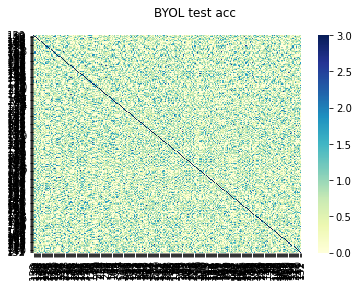

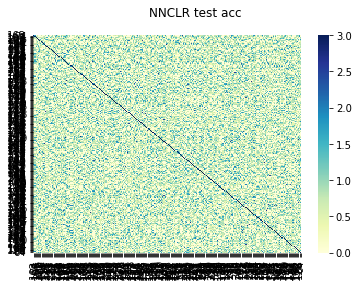

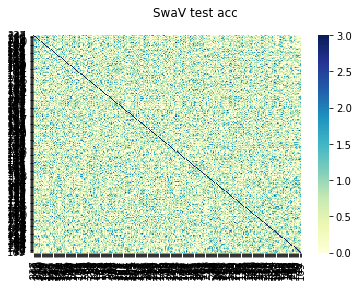

<Figure size 432x288 with 0 Axes>

In [8]:

normalization = {
    "ShearX":[0.0, 0.3],
    "ShearY":[0.0, 0.3],
    "TranslateX":[0, int(150 / 331.0 * 32)],
    "TranslateY":[0, int(150 / 331.0 * 32)],
    "Rotate":[-30, 30],
    "Color":[0.1, 1.9],
    "Posterize":[4, 8],
    "Solarize":[0, 1],
    "Contrast":[0.1,1.9],
    "Sharpness":[0.1, 1.9],
    "Brightness":[0.1, 1.9]
}

def chromo_distance(c1, c2):
    # hammming distance plus intensity differnece
    eq = np.array([int(c1_i[0] == c2_i[0]) for c1_i, c2_i in zip(c1, c2)])
    c1_i = np.array([c[1] for c in c1])
    c2_i = np.array([c[1] for c in c2])
    return sum(eq * np.abs(c2_i - c1_i))

def chromo_distance2(c1, c2, normalization=normalization):
    # intensity difference
    distance = 0
    for c1_i in c1:
        for c2_i in c2:
            if c1_i[0] == c2_i[0]:
                distance+= 1-abs(normalize(c1_i, normalization)[1] - normalize(c2_i, normalization)[1])

    return distance

def chromo_distance3(c1, c2):
    # number of same operators
    similarity = 0
    for c1_i in c1:
        for c2_i in c2:
            if c1_i[0] == c2_i[0]:
                similarity += 1
    return similarity


def normalize(c, normalization):
    return [c[0], (c[1] - normalization[c[0]][0]) / (normalization[c[0]][1] - normalization[c[0]][0])]



# sort based on accuracy and visualzie difference in chromosomes
for acc in accuracies:
    chromo_df = chromo_df.sort_values(by=acc)
    inds = chromo_df.index
    dist_mat = []
    for i in inds:
        dist_row = []
        for j in inds:
            c1 = chromos[str(i)]
            c2 = chromos[str(j)]
            dist_row.append(chromo_distance2(c1, c2))
        dist_mat.append(dist_row)
    sns.heatmap(data=dist_mat, xticklabels=inds, yticklabels=inds, cmap="YlGnBu")
    plt.suptitle(acc)
    plt.show()
    plt.clf()
            

Cosine similarity of distance matrices. 

To understand how the different ssl approaches are working we will compute the cosine similarity of all four matrices resulting in pairwise CxC similarity matrices where C is the number of chromosomes. 

In [9]:
compare_mats = combinations(list(range(len(distance_mats))), 2)
compare_mats

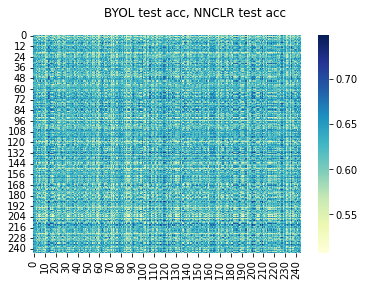

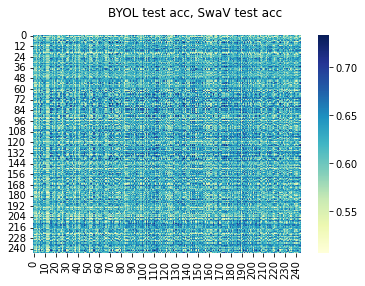

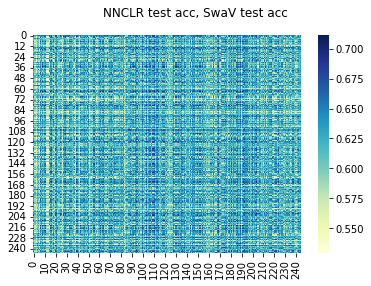

<Figure size 432x288 with 0 Axes>

In [10]:
compare_mats = list(combinations(list(range(len(distance_mats))), 2))
for i1, i2 in compare_mats:
    mat = cosine_similarity(distance_mats[i1], distance_mats[i2])
    sns.heatmap(data=mat, cmap="YlGnBu")
    plt.suptitle(f"{accuracies[i1]}, {accuracies[i2]}")
    plt.show()
    plt.clf()

It appears that there is a lot of similarity between the different test accuracies

Ordering based on losses:

In [13]:
# sort based on test acc and test loss and then compute the distance matrix between chromosomes for each method
losses = [c for c in chromo_df.columns if "loss" in c]
losses

['BYOL test loss', 'NNCLR test loss', 'SwaV test loss']

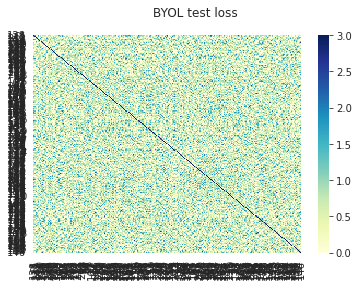

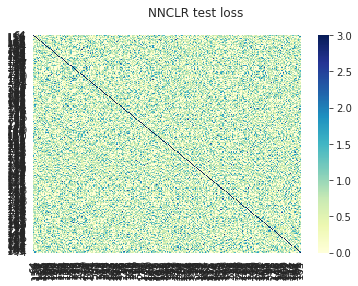

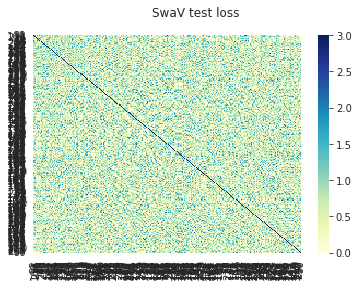

<Figure size 432x288 with 0 Axes>

In [16]:
# sort based on accuracy and visualzie difference in chromosomes
for loss in losses:
    chromo_df = chromo_df.sort_values(by=loss)
    inds = chromo_df.index
    dist_mat = []
    for i in inds:
        dist_row = []
        for j in inds:
            c1 = chromos[str(i)]
            c2 = chromos[str(j)]
            dist_row.append(chromo_distance2(c1, c2))
        dist_mat.append(dist_row)
    sns.heatmap(data=dist_mat, xticklabels=inds, yticklabels=inds, cmap="YlGnBu")
    plt.suptitle(loss)
    plt.show()
    plt.clf()

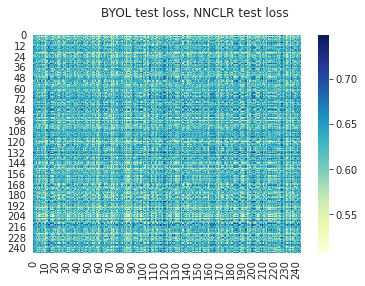

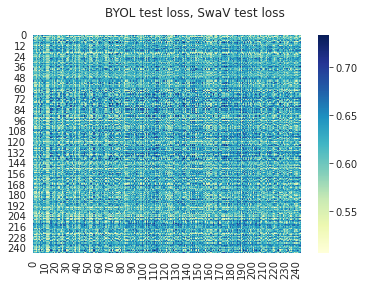

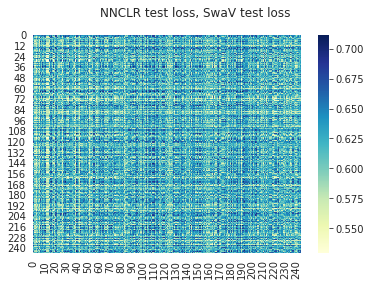

<Figure size 432x288 with 0 Axes>

In [17]:
compare_mats = list(combinations(list(range(len(distance_mats))), 2))
for i1, i2 in compare_mats:
    mat = cosine_similarity(distance_mats[i1], distance_mats[i2])
    sns.heatmap(data=mat, cmap="YlGnBu")
    plt.suptitle(f"{losses[i1]}, {losses[i2]}")
    plt.show()
    plt.clf()

Scattered boxplots of performance

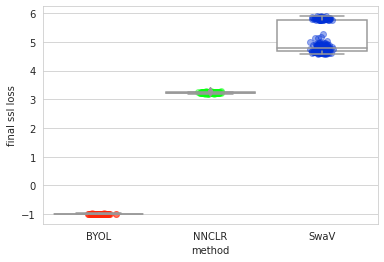

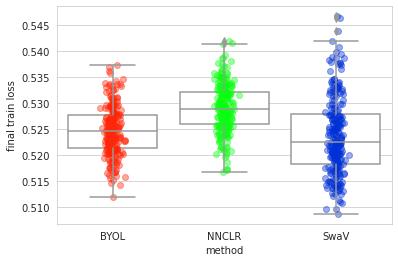

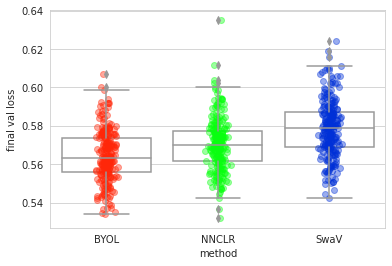

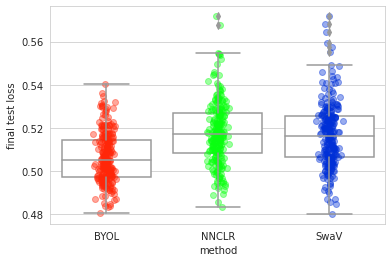

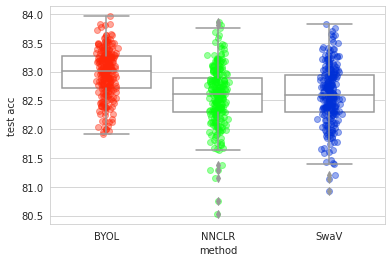

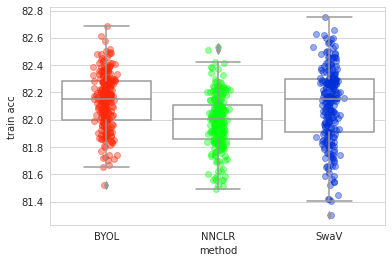

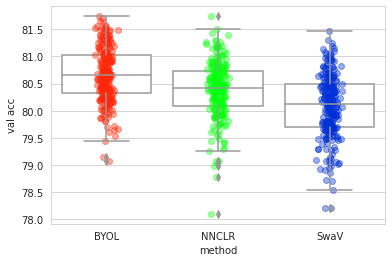

In [18]:
sns.set_style("whitegrid")
for col in [c for c in vals.columns if ("loss" in c or "acc" in c)]:
    plt.clf()
    df = vals[["method", col]]
    sns.boxplot(data=vals, x="method", y=col, color='white')
    palette = ['#FF2709', '#09FF10', '#0030D7', '#FA70B5']
    scatter_x = []
    scatter_y = []
    color = []
    for i, method in enumerate(df["method"].unique()):
        df_i = df[df["method"] == method]
        for val in df_i[col]:
            scatter_x.append(np.random.normal(i, 0.04))
            scatter_y.append(val)
            color.append(palette[i])
            plt.scatter(np.random.normal(i, 0.04), val, alpha=0.4, color=palette[i])
#     print(len(scatter_x))
#     print(len(scatter_y))
#     print(len(color))
#     sns.scatterplot(x=scatter_x, y=scatter_y, color=color)
    plt.show()
    

We see an interesting pattern with the ssl loss and SwaV, there appears to be two distinct groups. 

For test loss, We see BYOL has best results overall, but SwaV and NNCLR appear to be more sensitive to the changes in augmentation. 

In [12]:
from essl.chromosome import chromosome_generator

c = chromosome_generator(length=3)
len(c.gen_search_space())
print(c.gen_search_space()[0])
print(c())

[['ShearX', 0.242935977415552], ['ShearY', 0.26363686138640763], ['TranslateX', 2]]
[['Brightness', 1.1647239856955447], ['TranslateY', 13], ['ShearX', 0.029627518023534347]]


/home/noah/.conda/envs/ESSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
